<a href="https://colab.research.google.com/github/ShilpaPF/premier-league-predictions/blob/main/Football_Premier_League.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the dataset
file_path = "/content/drive/MyDrive/Premier_League_Data.csv"
df = pd.read_csv(file_path)

# Create a mapping from numeric codes to actual team names
team_mapping = dict(enumerate(df['Team'].unique()))

# Display basic information about the dataset
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2721 entries, 0 to 2720
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               2721 non-null   int64  
 1   Date                     2721 non-null   object 
 2   Time                     2721 non-null   object 
 3   Competition              2721 non-null   object 
 4   Round                    2721 non-null   object 
 5   Day                      2721 non-null   object 
 6   Venue                    2721 non-null   object 
 7   Result                   2721 non-null   object 
 8   Goals For                2721 non-null   int64  
 9   Goals Against            2721 non-null   int64  
 10  Opponent                 2721 non-null   object 
 11  Expected Goals           2721 non-null   float64
 12  Expected Goals Against   2721 non-null   float64
 13  Possession               2721 non-null   int64  
 14  Attendance              

In [3]:
# Check for missing values
print(df.isnull().sum())

Unnamed: 0                    0
Date                          0
Time                          0
Competition                   0
Round                         0
Day                           0
Venue                         0
Result                        0
Goals For                     0
Goals Against                 0
Opponent                      0
Expected Goals                0
Expected Goals Against        0
Possession                    0
Attendance                  880
Captain                       0
Formation                     0
Referee                       0
Match Report                  0
Notes                      2721
Shots                         0
Shots on Target               0
Distance                      1
Free Kicks                    0
Penalty Kicks                 0
Penalty Kicks Attempted       0
Season                        0
Team                          0
dtype: int64


In [4]:
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Feature engineering
df['Day_of_Week'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Goal_Difference'] = df['Goals For'] - df['Goals Against']
df['Goal_Ratio'] = df['Goals For'] / (df['Goals Against'] + 1)  # Add 1 to avoid division by zero
df['Shot_Accuracy'] = df['Shots on Target'] / df['Shots']
df['Expected_Goal_Difference'] = df['Expected Goals'] - df['Expected Goals Against']

In [5]:
#Select features for clustering
cluster_features = ['Goals For', 'Goals Against', 'Expected Goals', 'Expected Goals Against', 'Possession', 'Shots', 'Shots on Target']

# Prepare data for clustering
X_cluster = df[cluster_features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

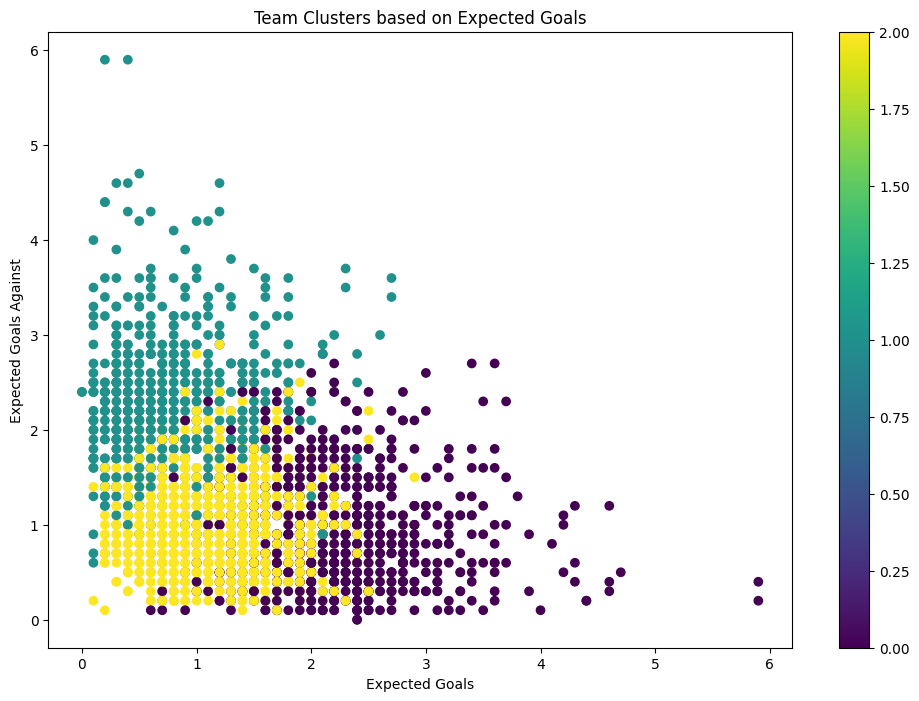

In [6]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['Expected Goals'], df['Expected Goals Against'], c=df['Cluster'], cmap='viridis')
plt.xlabel('Expected Goals')
plt.ylabel('Expected Goals Against')
plt.title('Team Clusters based on Expected Goals')
plt.colorbar(scatter)
plt.show()

In [7]:
# Print cluster centroids
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroid_df = pd.DataFrame(centroids, columns=cluster_features)
print("Cluster Centroids:")
print(centroid_df)

Cluster Centroids:
   Goals For  Goals Against  Expected Goals  Expected Goals Against  \
0   2.556833       0.994891        2.190166                0.962324   
1   0.748547       2.686047        0.789390                2.258430   
2   0.973600       0.884000        1.100160                1.060640   

   Possession      Shots  Shots on Target  
0   58.134100  17.740741         6.721584  
1   40.975291   7.985465         2.527616  
2   49.864000  11.272800         3.356000  


In [8]:
# Analyze clusters
for i in range(3):
    print(f"\nCluster {i}:")
    print(df[df['Cluster'] == i]['Team'].value_counts())
    print(df[df['Cluster'] == i][cluster_features].mean())


Cluster 0:
Team
Manchester City             98
Liverpool                   91
Chelsea                     69
Manchester United           55
Tottenham Hotspur           53
Arsenal                     52
Leicester City              49
Leeds United                35
West Ham United             35
Brighton and Hove Albion    34
Aston Villa                 30
Southampton                 29
Newcastle United            27
Everton                     22
Crystal Palace              20
Wolverhampton Wanderers     20
Burnley                     14
Watford                     11
Brentford                   11
Fulham                       9
Bournemouth                  6
Sheffield United             5
Nottingham Forest            3
Norwich City                 3
West Bromwich Albion         2
Name: count, dtype: int64
Goals For                  2.556833
Goals Against              0.994891
Expected Goals             2.190166
Expected Goals Against     0.962324
Possession                58.134100
Sh

In [9]:
# Convert categorical variables to numeric
le = LabelEncoder()
categorical_cols = ['Team', 'Opponent', 'Venue', 'Result', 'Captain', 'Formation', 'Referee', 'Competition', 'Round', 'Day']
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

In [10]:
# Map team numbers back to names
df['Team'] = df['Team'].map(team_mapping)

In [11]:
# Remove outliers using IQR method
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

numeric_columns = ['Goals For', 'Goals Against', 'Expected Goals', 'Expected Goals Against', 'Possession', 'Shots', 'Shots on Target']

print("Shape before removing outliers:", df.shape)
df = remove_outliers(df, numeric_columns)
print("Shape after removing outliers:", df.shape)


Shape before removing outliers: (2721, 36)
Shape after removing outliers: (2544, 36)


In [12]:
# Display all column names and their data types
print("All columns and their data types:")
print(df.dtypes)


All columns and their data types:
Unnamed: 0                           int64
Date                        datetime64[ns]
Time                                object
Competition                          int64
Round                                int64
Day                                  int64
Venue                                int64
Result                               int64
Goals For                            int64
Goals Against                        int64
Opponent                             int64
Expected Goals                     float64
Expected Goals Against             float64
Possession                           int64
Attendance                         float64
Captain                              int64
Formation                            int64
Referee                              int64
Match Report                        object
Notes                              float64
Shots                                int64
Shots on Target                      int64
Distance            

In [13]:
# Identify numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
print("\nNumeric columns found:", numeric_cols.tolist())


Numeric columns found: ['Unnamed: 0', 'Competition', 'Round', 'Day', 'Venue', 'Result', 'Goals For', 'Goals Against', 'Opponent', 'Expected Goals', 'Expected Goals Against', 'Possession', 'Attendance', 'Captain', 'Formation', 'Referee', 'Notes', 'Shots', 'Shots on Target', 'Distance', 'Free Kicks', 'Penalty Kicks', 'Penalty Kicks Attempted', 'Season', 'Day_of_Week', 'Month', 'Year', 'Goal_Difference', 'Goal_Ratio', 'Shot_Accuracy', 'Expected_Goal_Difference', 'Cluster']


In [14]:
# Calculate average goals scored by each team
team_avg_goals = df.groupby('Team')['Goals For'].mean().sort_values(ascending=False)
# Select top 10 scoring teams
top_10_teams = team_avg_goals.head(10).index

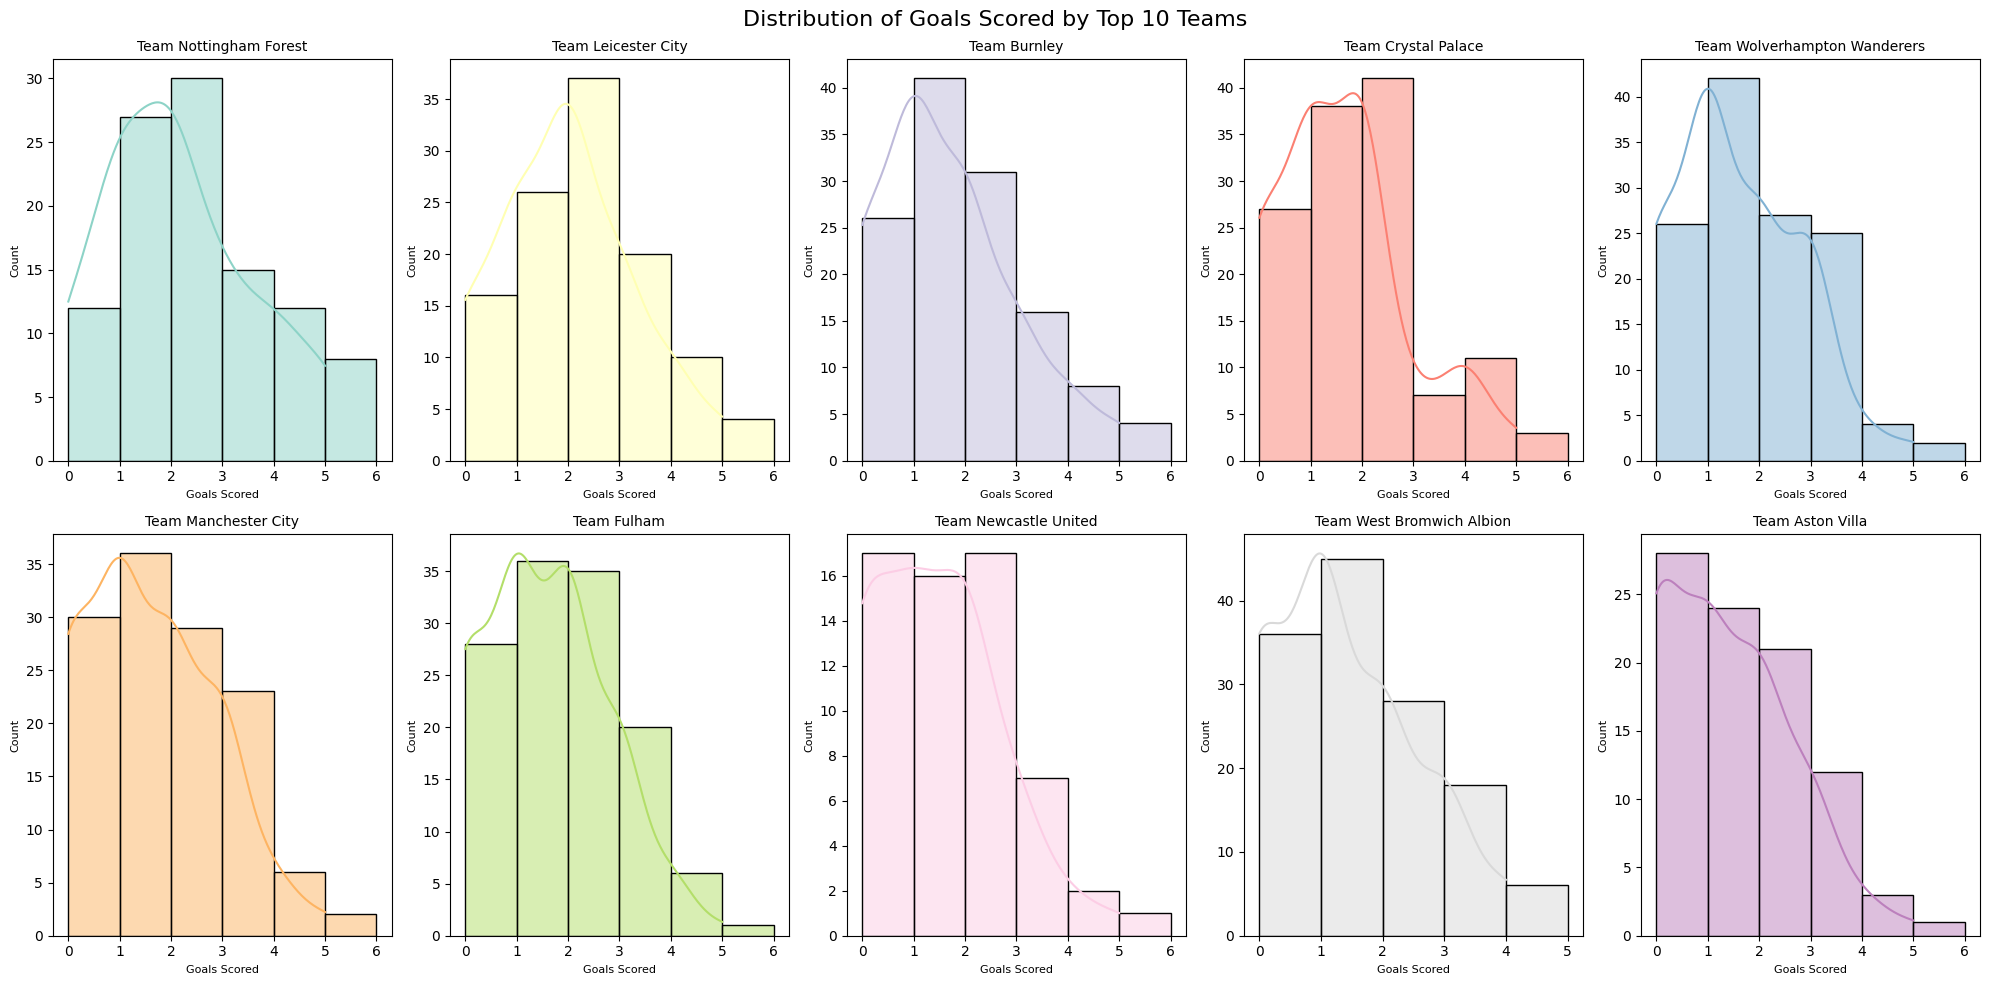

In [15]:
# Create a 2x5 subplot for the top 10 teams
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle('Distribution of Goals Scored by Top 10 Teams', fontsize=16)

for i, team in enumerate(top_10_teams):
    row = i // 5
    col = i % 5
    ax = axes[row, col]

    team_data = df[df['Team'] == team]
    sns.histplot(data=team_data, x='Goals For', kde=True, bins=range(0, int(team_data['Goals For'].max()) + 2),
                 color=plt.cm.Set3(i), ax=ax)

    ax.set_title(team_mapping.get(team, f'Team {team}'), fontsize=10)
    ax.set_xlabel('Goals Scored', fontsize=8)
    ax.set_ylabel('Count', fontsize=8)

plt.tight_layout()
plt.show()


In [16]:
# Print average goals for top 10 teams
print("Average goals scored by top 10 teams:")
print(team_avg_goals.head(10))

Average goals scored by top 10 teams:
Team
Nottingham Forest          2.115385
Leicester City             1.946903
Burnley                    1.611111
Crystal Palace             1.574803
Wolverhampton Wanderers    1.563492
Manchester City            1.563492
Fulham                     1.547619
Newcastle United           1.400000
West Bromwich Albion       1.345865
Aston Villa                1.337079
Name: Goals For, dtype: float64


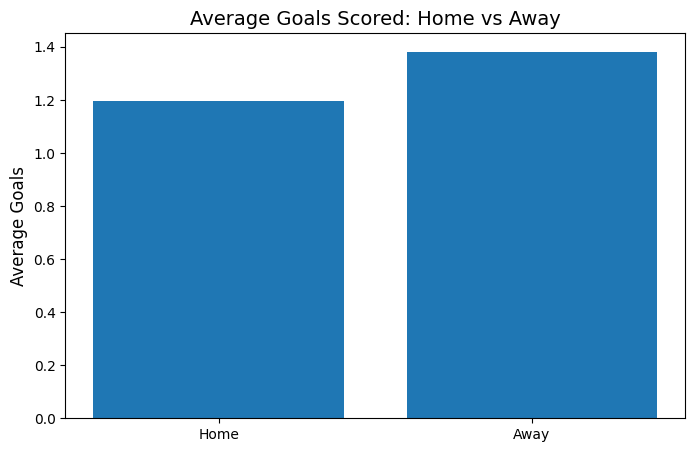

In [17]:
# Visualize home vs away performance
home_performance = df[df['Venue'] == 0]['Goals For'].mean()
away_performance = df[df['Venue'] == 1]['Goals For'].mean()
plt.figure(figsize=(8, 5))
plt.bar(['Home', 'Away'], [home_performance, away_performance])
plt.title('Average Goals Scored: Home vs Away', fontsize=14)
plt.ylabel('Average Goals', fontsize=12)
plt.show()

In [18]:
# Print summary for goals scored by each team
team_goals = df.groupby('Team')['Goals For'].agg(['mean', 'median', 'max'])
print("\nGoals scored by each team:")
print(team_goals.sort_values('mean', ascending=False))


Goals scored by each team:
                              mean  median  max
Team                                           
Nottingham Forest         2.115385     2.0    5
Leicester City            1.946903     2.0    5
Burnley                   1.611111     1.0    5
Crystal Palace            1.574803     1.0    5
Wolverhampton Wanderers   1.563492     1.0    5
Manchester City           1.563492     1.0    5
Fulham                    1.547619     1.0    5
Newcastle United          1.400000     1.0    5
West Bromwich Albion      1.345865     1.0    4
Aston Villa               1.337079     1.0    5
Tottenham Hotspur         1.206349     1.0    4
Arsenal                   1.174603     1.0    4
Southampton               1.171875     1.0    4
West Ham United           1.165414     1.0    5
Brentford                 1.068702     1.0    5
Liverpool                 1.045802     1.0    4
Sheffield United          1.044444     1.0    4
Manchester United         1.016949     1.0    4
Chelsea     

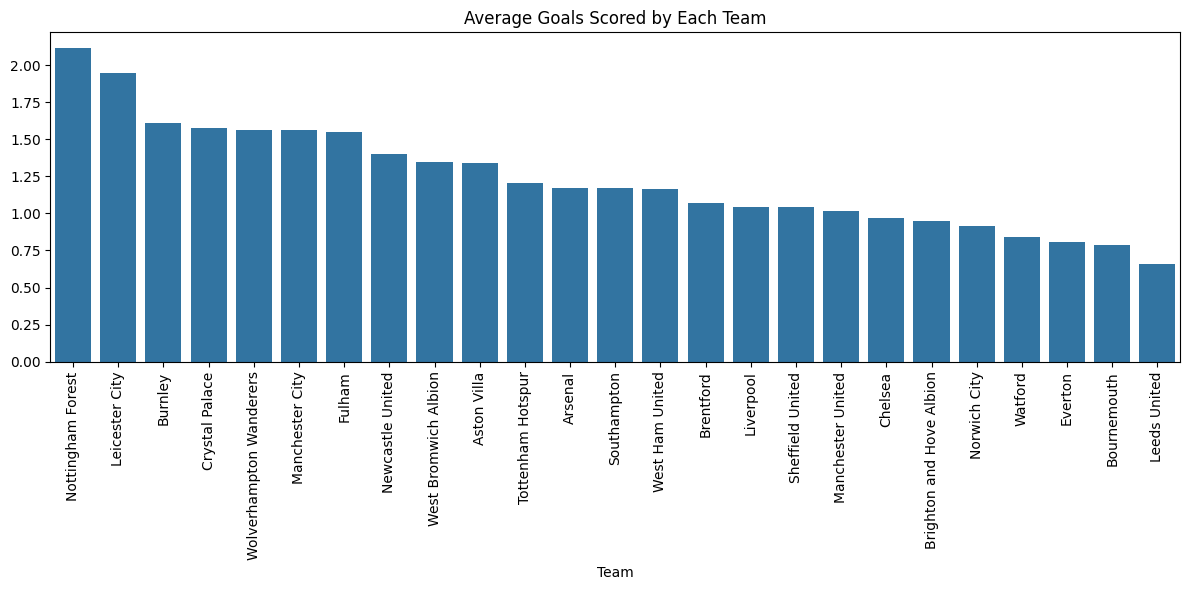

In [19]:
# Visualizations
plt.figure(figsize=(12, 6))
sns.barplot(x=team_avg_goals.index, y=team_avg_goals.values)
plt.title('Average Goals Scored by Each Team')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

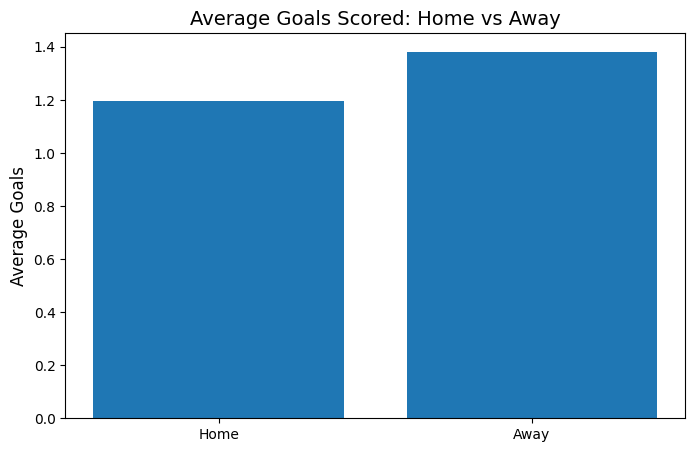

In [20]:
# Home vs Away performance
home_performance = df[df['Venue'] == 0]['Goals For'].mean()
away_performance = df[df['Venue'] == 1]['Goals For'].mean()
plt.figure(figsize=(8, 5))
plt.bar(['Home', 'Away'], [home_performance, away_performance])
plt.title('Average Goals Scored: Home vs Away', fontsize=14)
plt.ylabel('Average Goals', fontsize=12)
plt.show()

In [21]:
# Prepare data for modeling
features = ['Venue', 'Opponent', 'Expected Goals', 'Expected Goals Against', 'Possession', 'Shots',
            'Shots on Target', 'Distance', 'Free Kicks', 'Penalty Kicks', 'Penalty Kicks Attempted',
            'Goal_Difference', 'Goal_Ratio', 'Shot_Accuracy', 'Expected_Goal_Difference']
X = df[features]
y = df['Result']

# Check for NaN values
print("Columns with NaN values:")
print(X.isna().sum())


Columns with NaN values:
Venue                       0
Opponent                    0
Expected Goals              0
Expected Goals Against      0
Possession                  0
Shots                       0
Shots on Target             0
Distance                    1
Free Kicks                  0
Penalty Kicks               0
Penalty Kicks Attempted     0
Goal_Difference             0
Goal_Ratio                  0
Shot_Accuracy               1
Expected_Goal_Difference    0
dtype: int64


In [22]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [24]:
# Scale the imputed features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [25]:
# Define models
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
svm = SVC(probability=True, random_state=42)

# Create a dictionary of models
models = {
    'Random Forest': rf,
    'Gradient Boosting': gb,
    'SVM': svm
}

In [26]:
# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {accuracy:.4f}")
    print(f"{name} Classification Report:")
    print(classification_report(y_test, y_pred))


Random Forest Accuracy: 1.0000
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       132
           1       1.00      1.00      1.00       183
           2       1.00      1.00      1.00       194

    accuracy                           1.00       509
   macro avg       1.00      1.00      1.00       509
weighted avg       1.00      1.00      1.00       509


Gradient Boosting Accuracy: 1.0000
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       132
           1       1.00      1.00      1.00       183
           2       1.00      1.00      1.00       194

    accuracy                           1.00       509
   macro avg       1.00      1.00      1.00       509
weighted avg       1.00      1.00      1.00       509


SVM Accuracy: 0.9902
SVM Classification Report:
              precision    recall  f1-score

In [27]:
# Feature importance (for Random Forest)
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 5 Most Important Features:")
print(feature_importance.head())


Top 5 Most Important Features:
                     feature  importance
11           Goal_Difference    0.489031
12                Goal_Ratio    0.341771
14  Expected_Goal_Difference    0.043739
3     Expected Goals Against    0.027928
2             Expected Goals    0.022732


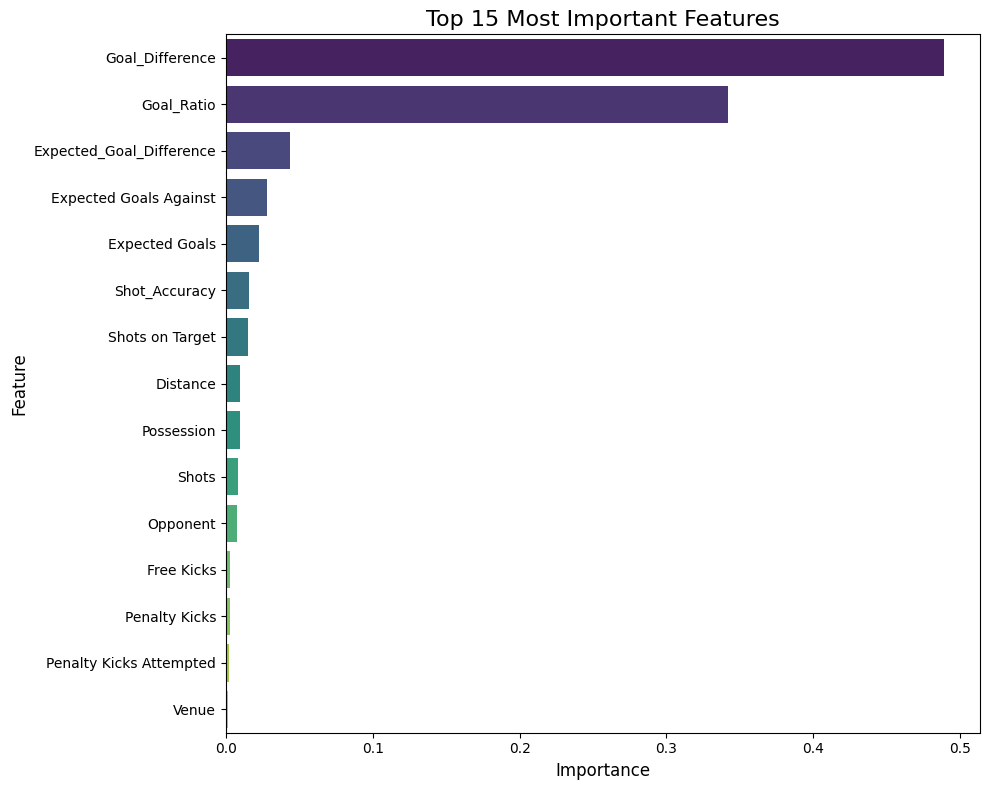

In [28]:
# Create a horizontal bar plot for feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15), palette='viridis')
plt.title('Top 15 Most Important Features', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()


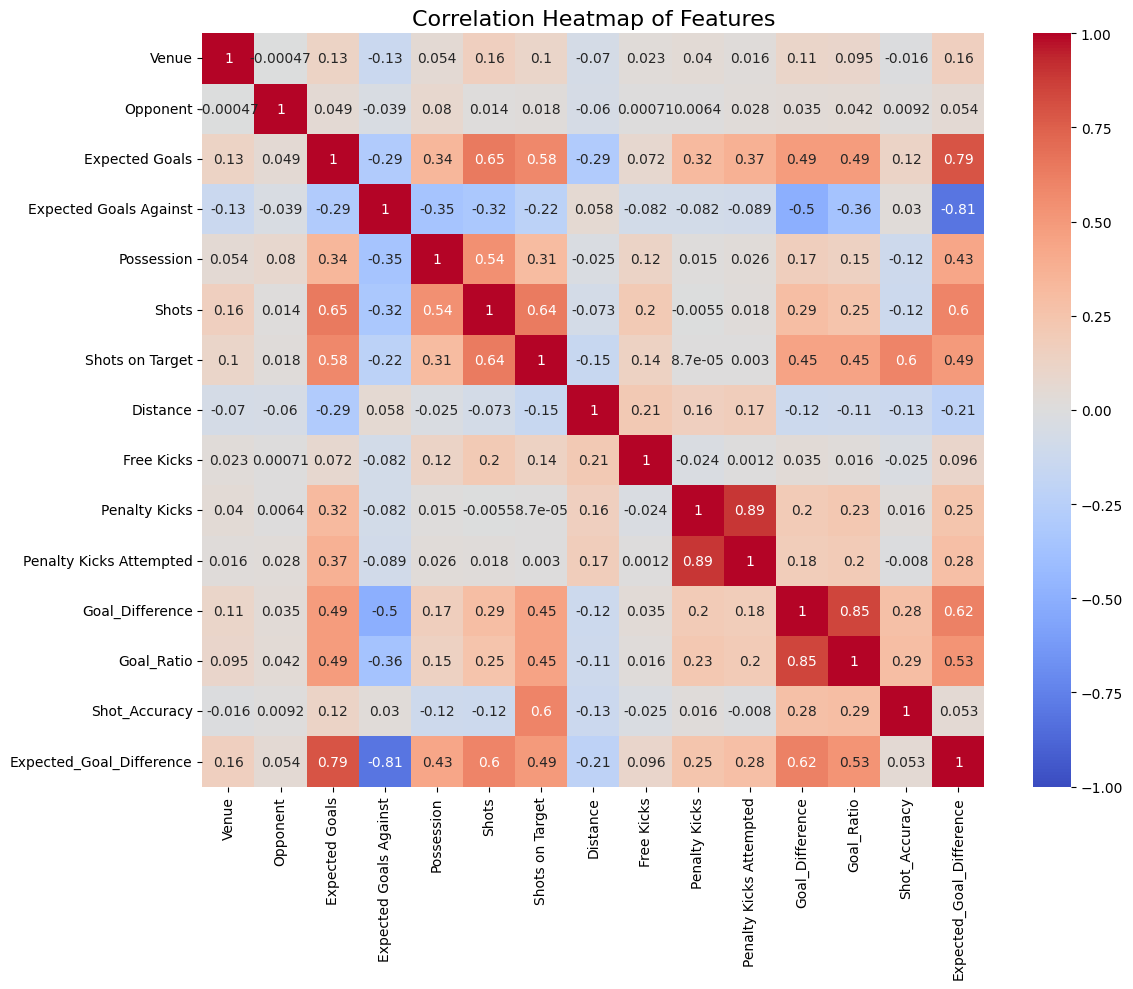

In [29]:
# Create a correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Features', fontsize=16)
plt.tight_layout()
plt.show()

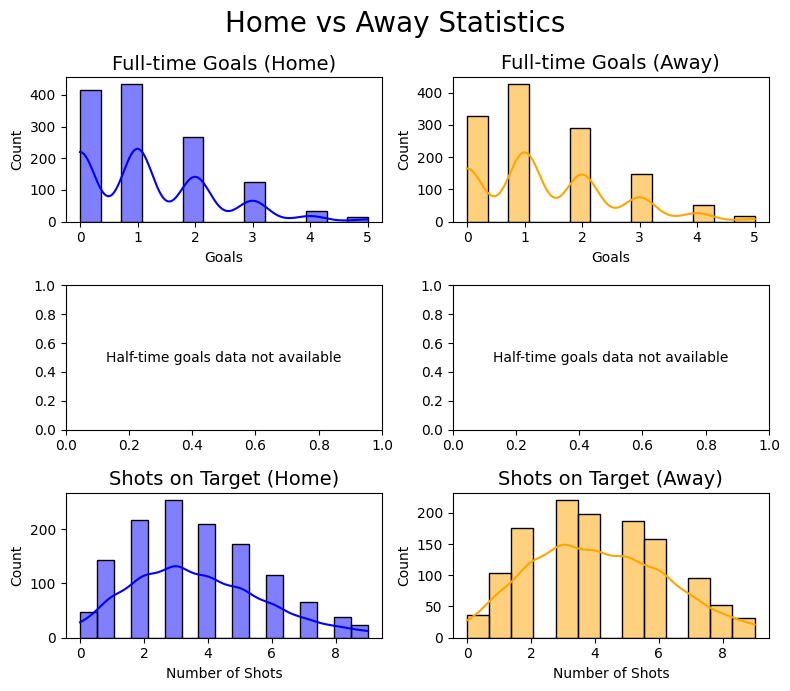

In [30]:
# Adjacent graphs for full-time home & away goals, half-time home & away goals, and home & away shots on target
fig, axs = plt.subplots(3, 2, figsize=(8, 7))
fig.suptitle('Home vs Away Statistics', fontsize=20)

# Full-time goals
sns.histplot(data=df[df['Venue'] == 0], x='Goals For', kde=True, color='blue', ax=axs[0, 0])
axs[0, 0].set_title('Full-time Goals (Home)', fontsize=14)
axs[0, 0].set_xlabel('Goals')
sns.histplot(data=df[df['Venue'] == 1], x='Goals For', kde=True, color='orange', ax=axs[0, 1])
axs[0, 1].set_title('Full-time Goals (Away)', fontsize=14)
axs[0, 1].set_xlabel('Goals')

# Half-time goals (assuming 'HG' is the column for half-time goals)
if 'HG' in df.columns:
    sns.histplot(data=df[df['Venue'] == 0], x='HG', kde=True, color='blue', ax=axs[1, 0])
    axs[1, 0].set_title('Half-time Goals (Home)', fontsize=14)
    axs[1, 0].set_xlabel('Goals')
    sns.histplot(data=df[df['Venue'] == 1], x='HG', kde=True, color='orange', ax=axs[1, 1])
    axs[1, 1].set_title('Half-time Goals (Away)', fontsize=14)
    axs[1, 1].set_xlabel('Goals')
else:
    axs[1, 0].text(0.5, 0.5, 'Half-time goals data not available', ha='center', va='center')
    axs[1, 1].text(0.5, 0.5, 'Half-time goals data not available', ha='center', va='center')

# Shots on target
sns.histplot(data=df[df['Venue'] == 0], x='Shots on Target', kde=True, color='blue', ax=axs[2, 0])
axs[2, 0].set_title('Shots on Target (Home)', fontsize=14)
axs[2, 0].set_xlabel('Number of Shots')
sns.histplot(data=df[df['Venue'] == 1], x='Shots on Target', kde=True, color='orange', ax=axs[2, 1])
axs[2, 1].set_title('Shots on Target (Away)', fontsize=14)
axs[2, 1].set_xlabel('Number of Shots')

plt.tight_layout()
plt.show()


In [31]:
# Create the home vs away performance plot
plt.figure(figsize=(8, 5))
df['Points'] = df['Result'].map({0: 0, 1: 1, 2: 3})


<Figure size 800x500 with 0 Axes>

In [32]:
# Calculate home and away performance separately
home_performance = df[df['Venue'] == 0].groupby('Team')['Points'].mean()
away_performance = df[df['Venue'] == 1].groupby('Team')['Points'].mean()


In [33]:
# Combine home and away performance
performance = pd.DataFrame({
    'Home': home_performance,
    'Away': away_performance
}).reset_index()


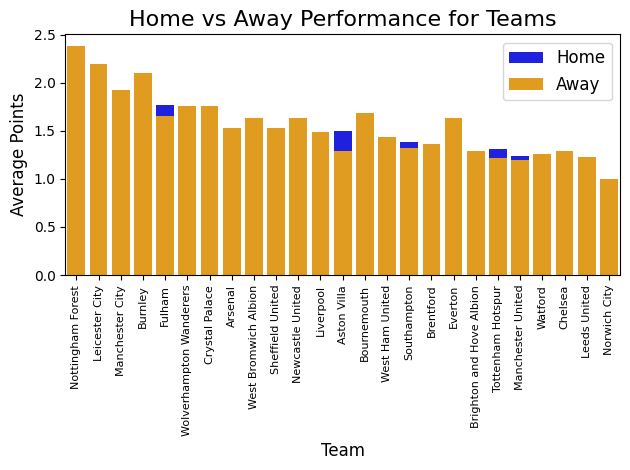

In [34]:
# Sort teams by total performance (home + away)
performance['Total'] = performance['Home'] + performance['Away']
performance = performance.sort_values('Total', ascending=False)
# Create the plot
sns.barplot(data=performance, x='Team', y='Home', color='blue', label='Home')
sns.barplot(data=performance, x='Team', y='Away', color='orange', label='Away')

plt.title('Home vs Away Performance for Teams', fontsize=16)
plt.xlabel('Team', fontsize=12)
plt.ylabel('Average Points', fontsize=12)
plt.xticks(rotation=90, fontsize=8)  # Reduced font size for readability
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()